# ODC Basic Functionality




## What you'll discover using ODC.

-  Shift in paradigm from scene based analysis to pixel based.
-  A simple, standard, and extensible way to interact with and perform analysis on data.
-  Allow users to define exactly in what state data is to be delivered in terms of projection, resolution, bands and datasets.
-  Easily create subsets or derivative products that are managed and tracked by the ODC.
-  Provide a base set of functions and tools that make analysis more simple!


### Let's get right into it by loading a cube.

In the sample below we use the datacube.load command to load the RGB and Quality Assurance(QA) bands from the AWS Landsat archive. Landsat 8 has a return period of 16 days capturing over 24 snapshots a year so care should be taken when requesting a datacube as large geographical or time extents can quickly over fill memory and generate huge lag. 

For our first visualisation we'll load a single time slice of the full geographical extent indexed and then proceed to select a smaller zone to explore through time.

It should be noted that images on AWS are referenced to WGS 84 so the extent bounds that are entered into the datacube.load() must match the coordinate system in which they're being stored. 

The datacube.load() command also reprojects into a coordinate system in the below datacube load we automatically generate an EPSG code from the lat/long of the provided extent. 

If you'd like to visualize other bands add any of the below measurements to the `datacube.load(measurements= ...`:

Landsat 8 measurement options are:

             ('1', 'coastal_aerosol')
             ('2', 'blue')
             ('3', 'green')
             ('4', 'red')
             ('5', 'nir')
             ('6', 'swir1')
             ('7', 'swir2')
             ('8', 'panchromatic')
             ('9', 'cirrus')
             ('10', 'lwir1')
             ('11', 'lwir2')
             ('QUALITY', 'quality')]


In [2]:
## First we load the libraries that are going to utilise

%matplotlib notebook
import datacube # Load the datacube library
import datetime
import numpy as np
import json
import matplotlib.pyplot as plt
from utils.utils import (
    lat_lon_to_epsg,
    three_band_image,
    load_config_extents,
    transform_to_wgs,
    load_config)


In [6]:
%%time

dc = datacube.Datacube(app='load-data-example')

# Let's request a datacube!!

#if you want to load the case study area that has been chosen in the landing page uncomment the below
# the code marked [LANDING PAGE EXTENT LOAD].

lon_min,lon_max,lat_min,lat_max = [146.30,146.83,-43.54,-43.20]
date_range = (
    datetime.datetime(2017, 1, 1),
    datetime.datetime(2018, 1, 1)) 


#config = load_config('./configIndex.txt')   #[LANDING PAGE EXTENT LOAD]
#lon_min,lon_max = config['lon']             #[LANDING PAGE EXTENT LOAD]
#lat_min,lat_max = config['lat']             #[LANDING PAGE EXTENT LOAD]
#date_range=tuple(sorted(config['time']))    #[LANDING PAGE EXTENT LOAD]


# Get the EPSG of a WGS UTM coordinate reference system that is appropriate for our data
EPSG = lat_lon_to_epsg(lat_max,lon_min)

data_cube = dc.load(
    product='ls8_level1_usgs',
    x=(lon_min, lon_max),
    y=(lat_min, lat_max), 
    output_crs='epsg:' + EPSG,
    resolution=(-30, 30),
    time = date_range, 
    measurements = ('red','green','blue','quality'))

CPU times: user 33.5 s, sys: 3.38 s, total: 36.9 s
Wall time: 2min


In [7]:
print(data_cube)

<xarray.Dataset>
Dimensions:  (time: 37, x: 1439, y: 1267)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-03T23:58:42.374786 ...
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
Data variables:
    red      (time, y, x) int16 13965 14398 15275 15624 15004 13273 11270 ...
    green    (time, y, x) int16 13767 14052 14824 15144 14751 13032 11156 ...
    blue     (time, y, x) int16 14225 14421 15204 15508 15189 13604 11835 ...
    quality  (time, y, x) int16 2800 2800 2800 2800 2800 2800 2800 2800 2800 ...
Attributes:
    crs:      epsg:32755


## Let's explore what a data cube is.

In the context of earth observation a data cube is a multi-dimensional array that will consistantly contain the dimensions of time and a spatial grid. Along these dimensions any number of measurements can be associated to these grids and will represent the measurement taken at a specific time and space. 

<img src="images/Data_Cube.png">

The ODC uses the XArray library http://xarray.pydata.org/en/stable/, the key to building effective ODC algorithms is to master the use of the xarray. Please click on the documention to find out more otherwise a number of examples are provided below.

They're also python libraries such as Dask http://dask.pydata.org/en/latest/ that can scale up computation of XArray to supercomputing, and cloud solutions. They're many other project utilising XArray and it becoming a standard for multi-dimenional data analysis.


In [8]:
%matplotlib notebook
# Pixel Drill by index through time
pixel_drill_index = data_cube.isel(x=[500], y=[1000])
print(pixel_drill_index)
print('----------------------------------------------')

# Pixel Drill by coordinates through time.
pixel_drill_coordinates = data_cube.sel(x=[-4788000], y=[1197000], method='nearest')
print(pixel_drill_coordinates)
print('----------------------------------------------')

# Pixel Drill by coordinates through time.
pixel_slice_index = data_cube.isel(x=slice(200,300), y=slice(200,300), time=2)
print(pixel_slice_index)


<xarray.Dataset>
Dimensions:  (time: 37, x: 1, y: 1)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-03T23:58:42.374786 ...
  * y        (y) float64 5.187e+06
  * x        (x) float64 4.581e+05
Data variables:
    red      (time, y, x) int16 5988 12339 20695 20597 6000 14938 6776 12790 ...
    green    (time, y, x) int16 6652 12497 20690 20136 6636 14783 7123 12620 ...
    blue     (time, y, x) int16 7419 12678 22285 21359 7491 15937 7853 13692 ...
    quality  (time, y, x) int16 2720 2800 2800 2800 2720 2800 2800 2800 2720 ...
Attributes:
    crs:      epsg:32755
----------------------------------------------
<xarray.Dataset>
Dimensions:  (time: 37, x: 1, y: 1)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-03T23:58:42.374786 ...
  * y        (y) float64 5.179e+06
  * x        (x) float64 4.431e+05
Data variables:
    red      (time, y, x) int16 6528 6525 28579 12248 6449 18529 5795 18697 ...
    green    (time, y, x) int16 6987 7003 27724 12491 6931 17894 6183 17808 

## Querying a data cube.

Our datacube can now be sliced, trimmed or querried with masks, you can basically sculpt any object out of the cube pixels.

<img src="images/pixel_drill.png">
<img src="images/line_drill.png">


<IPython.core.display.Javascript object>


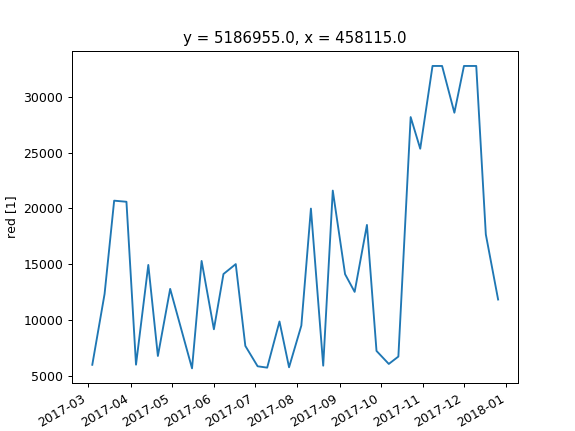

In [9]:
pixel_drill_index.red.plot()
#pixel_drill_index.green.plot()
#pixel_drill_index.blue.plot()

<xarray.Dataset>
Dimensions:  (month: 10)
Coordinates:
  * month    (month) int64 3 4 5 6 7 8 9 10 11 12
Data variables:
    red      (month) float64 1.347e+04 1.237e+04 9.7e+03 9.929e+03 1.065e+04 ...
    green    (month) float64 1.355e+04 1.22e+04 9.674e+03 9.771e+03 ...
    blue     (month) float64 1.448e+04 1.307e+04 1.056e+04 1.075e+04 ...
    quality  (month) float64 2.76e+03 2.824e+03 5.504e+03 5.531e+03 ...
---------------------------------
<xarray.Dataset>
Dimensions:  (x: 100)
Coordinates:
    time     datetime64[ns] 2017-03-19T23:58:32.578365
  * x        (x) float64 4.491e+05 4.491e+05 4.492e+05 4.492e+05 4.492e+05 ...
Data variables:
    red      (x) float64 2.383e+04 2.397e+04 2.424e+04 2.459e+04 2.488e+04 ...
    green    (x) float64 2.334e+04 2.347e+04 2.371e+04 2.403e+04 2.429e+04 ...
    blue     (x) float64 2.443e+04 2.457e+04 2.484e+04 2.517e+04 2.544e+04 ...
    quality  (x) float64 2.964e+03 2.923e+03 2.964e+03 2.964e+03 2.923e+03 ...


<IPython.core.display.Javascript object>


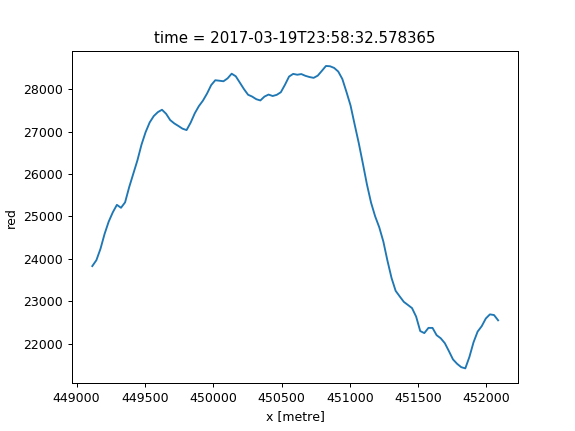

In [11]:
%matplotlib notebook
# Operations on cubes.
monthly_means = pixel_drill_coordinates.groupby('time.month').mean()
print(monthly_means)
print('---------------------------------')

y_cross_sections = pixel_slice_index.groupby('x').mean()
print(y_cross_sections)
y_cross_sections.red.plot()

Next we'll explore [Landsat 8 quality band](https://landsat.usgs.gov/collectionqualityband), each pixel in the QA band contains unsigned integers that represent bit-packed combinations of surface, atmospheric, and sensor conditions that can affect the overall usefulness of a given pixel.

Used effectively, QA bits improve the integrity of science investigations by indicating which pixels might be affected by instrument artifacts or subject to cloud contamination. The ODC has in built methods that transform the metadata of a specific product to a libary of masking templates. For example, you are able to build a cloud mask directly from the ODC library.


In [12]:
from datacube.storage import masking  # Import masking capabilities
print (masking.describe_variable_flags(ds)) #D escribe the masks available



                            bits  \
cirrus_confidence       [11, 12]   
cloud                        [4]   
cloud_confidence          [5, 6]   
cloud_shadow_conf         [7, 8]   
designated_fill              [0]   
radiometric_saturation    [2, 3]   
snow_ice_conf            [9, 10]   
terrain_occlusion            [1]   

                                                                   values  \
cirrus_confidence       {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
cloud                                             {'0': False, '1': True}   
cloud_confidence        {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
cloud_shadow_conf       {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
designated_fill                                   {'0': False, '1': True}   
radiometric_saturation  {'0': 'none', '1': '1-2', '2': '3-4', '3': '<=5'}   
snow_ice_conf           {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
terrain_occlusion                                 {'0': Fal

In [13]:
# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask = masking.make_mask(
    ds.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion = False)

print(clean_pixel_mask)

masked_cloud = ds.where(clean_pixel_mask)

print(masked_cloud)

<xarray.DataArray 'quality' (time: 1, y: 1267, x: 1439)>
array([[[False, False, ...,  True,  True],
        [False, False, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
<xarray.Dataset>
Dimensions:  (time: 1, x: 1439, y: 1267)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
Data variables:
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    blue     (time, y, x) float64 nan nan nan nan nan nan na

Next we'll display the RGB bands that we have extracted from our cube for the first time slice (time = 0) in order to visualise a comprehendible RGB image we apply a histogram equalisation on each band before displaying. We'll also create visualisation of the pixels that are occluding land areas.

<IPython.core.display.Javascript object>


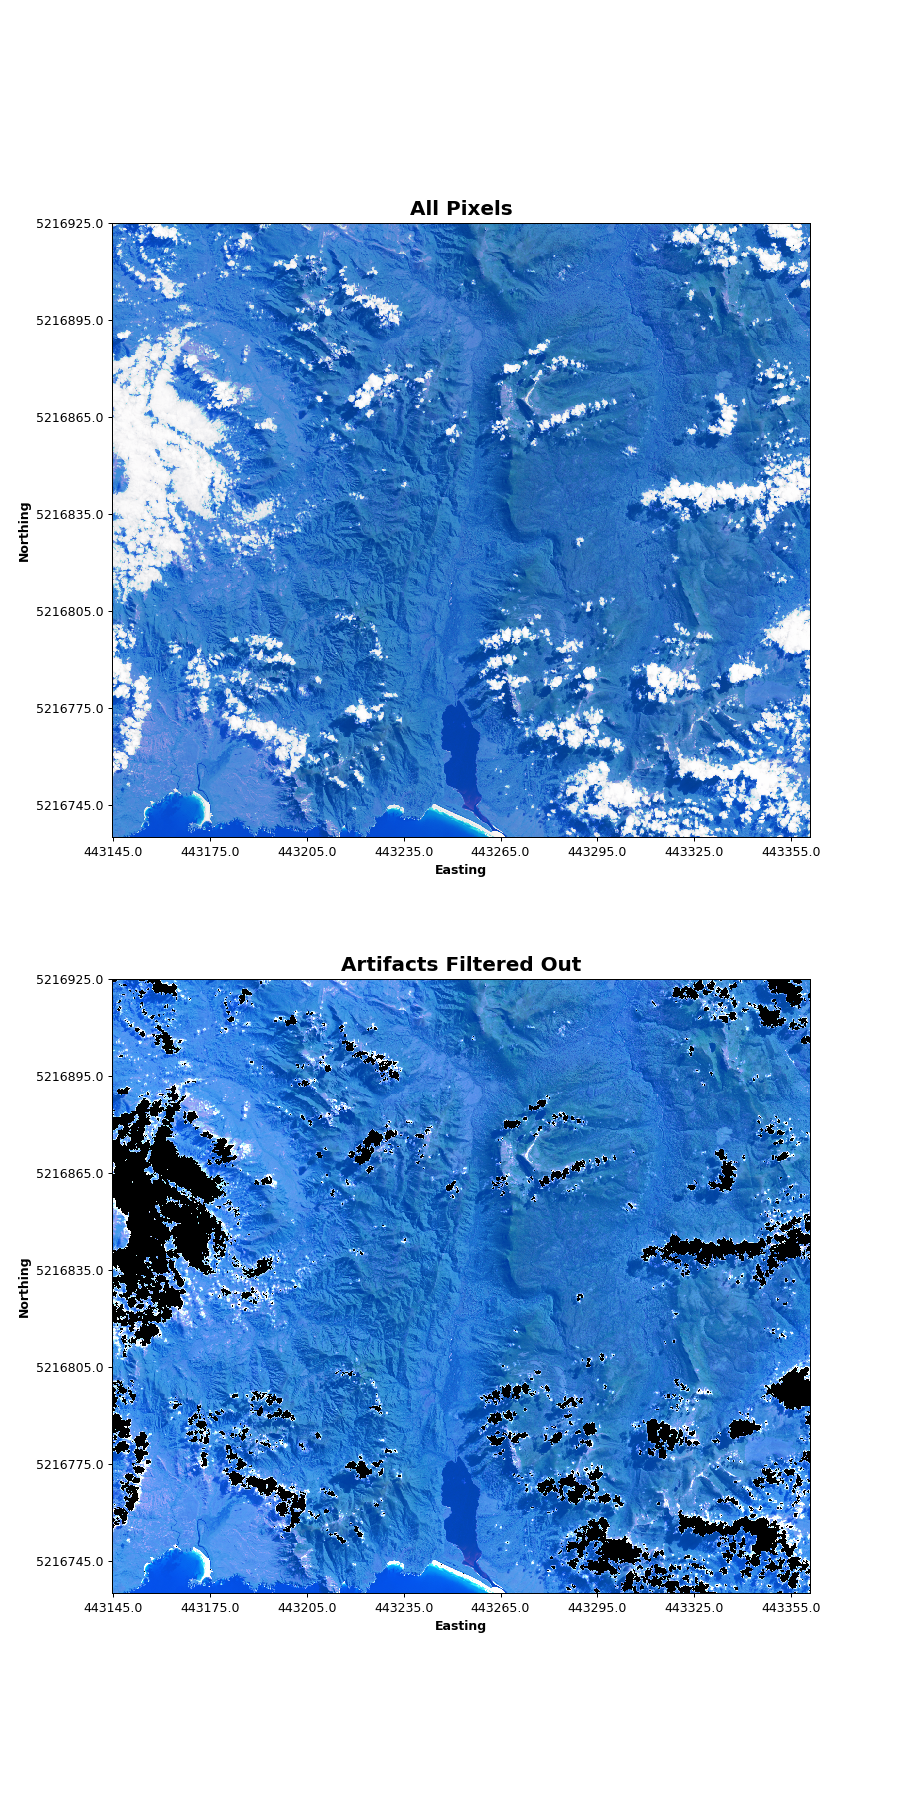

In [14]:
%matplotlib notebook

time = 0 ## Change this index to time step through the cube.

img_toshowNoMask = three_band_image(masked_cloud,bands = ['red', 'green', 'blue'], time = time)
img_toshow = three_band_image(ds,bands = ['red', 'green', 'blue'], time = time)
#fig, (ax1, ax2) = plt.subplots(2, 1)
fig = plt.figure(1, [10,20])

plt.subplot(211)
ax = plt.gca()
ax.set_title("All Pixels", fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')

plt.imshow(img_toshow)

plt.subplot(212)
ax = plt.gca()
ax.set_title("Artifacts Filtered Out", fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')
plt.imshow(img_toshowNoMask)

